#### Heart Mortality in USA by state - population over 35 years old  
Data:  
<a href=https://catalog.data.gov/dataset/heart-disease-mortality-data-among-us-adults-35-by-state-territory-and-county-a68e3>https://catalog.data.gov/dataset/heart-disease-mortality-data-among-us-adults-35-by-state-territory-and-county-a68e3</a>  

<b>Problem Statement and Project Life Cycle:</b>  
Using the heart mortality data is it possible to predict the gender to which a specifc observation belongs?  
To answer this problem the following steps are used to construct a set of multi-class classification models:
- Data is collected through data.gov
- Each feature/column in the dataset is analyzed to identify the data type of the feature and the number of null and non-null values.
- Preliminary analysis includes a histograms of:
    - Grouped mortality rate by state to observe the average heart mortality rate at state level.
    - Grouped mortality rate by state and gender classification to also observe the average heart mortality rate by gender and state.
- Feature engineering includes:
    - Coverting Location1 from type string to float as these are coordinates and will provide more meaninful information as numerical data types
    - Conversion of mortality rate to type float.
    - Coversion of location abbreviation, location description, geographic level, data value type, stratification 1, stratification 2, and location ID to catgorical variables.
    - Dummy encoding of categorical variables 
    - Log transformation of mortality rate to correct for the right skew in this variable.
    - Imputation of missing values in the mortality rate by using grouped median based on stratification 2(ethnicity) at the location(state) level
- Feature Selection:
    - Feature selection is done using the Generic Univariate Selector from scikit learn which ranks features based on importance calculated using F-Value from the ANOVA test.
- The data is modeled using:
    - Train/Test Split of 80%/20%
    - Logistic Regression Classifier
    - Gaussian Naive Bayes Classifier
    - Support Vector Machine CLassifier
    - Decision Tree Classifier
    - Random Forest Classifier
- For both tree classifiers the models are iterated over tree depth and the AUC accuracy is ploted for each iteration. The final models use the maximum depth of the tree which produces the highest AUC accuracy.
    
- Each model's AUC accuracy along with a confusion matrix of the results is reported at the end of each model.  
- Amongst all classifiers the Decision Tree classifier produces the best AUC accuracy of 71.1%

Libraries used in the project inlcude Pandas, Numpy, Matplotlib, Seaborn, and Scikit Learn

In [17]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [18]:
df = pd.read_csv('Heart Mortality Data.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59076 entries, 0 to 59075
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        59076 non-null  int64  
 1   LocationAbbr                59076 non-null  object 
 2   LocationDesc                59076 non-null  object 
 3   GeographicLevel             59076 non-null  object 
 4   DataSource                  59076 non-null  object 
 5   Class                       59076 non-null  object 
 6   Topic                       59076 non-null  object 
 7   Data_Value                  31899 non-null  float64
 8   Data_Value_Unit             59076 non-null  object 
 9   Data_Value_Type             59076 non-null  object 
 10  Data_Value_Footnote_Symbol  27177 non-null  object 
 11  Data_Value_Footnote         27177 non-null  object 
 12  StratificationCategory1     59076 non-null  object 
 13  Stratification1             590

In [20]:
df.rename(columns={'Data_Value':'Mortality Rate'}, inplace=True)
df.head()

,Year,LocationAbbr,LocationDesc,GeographicLevel,DataSource,Class,Topic,Mortality Rate,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,Data_Value_Footnote,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,TopicID,LocationID,Location 1
0,2015,AR,Arkansas,State,NVSS,Cardiovascular Diseases,Heart Disease Mortality,136.6,"per 100,000 population","Age-adjusted, 3-year Average Rate",NaN,NaN,Gender,Overall,Race/Ethnicity,Hispanic,T2,5,"(34.8982, -92.434)"
1,2015,AR,Arkansas,State,NVSS,Cardiovascular Diseases,Heart Disease Mortality,138.3,"per 100,000 population","Age-adjusted, 3-year Average Rate",NaN,NaN,Gender,Male,Race/Ethnicity,Hispanic,T2,5,"(34.8982, -92.434)"
2,2015,AR,Arkansas,State,NVSS,Cardiovascular Diseases,Heart Disease Mortality,130.4,"per 100,000 population","Age-adjusted, 3-year Average Rate",NaN,NaN,Gender,Female,Race/Ethnicity,Hispanic,T2,5,"(34.8982, -92.434)"
3,2015,AS,American Samoa,State,NVSS,Cardiovascular Diseases,Heart Disease Mortality,456.2,"per 100,000 population","Age-adjusted, 3-year Average Rate",NaN,NaN,Gender,Male,Race/Ethnicity,Overall,T2,60,"(-14.2766, -170.367)"
4,2015,AS,American Samoa,State,NVSS,Cardiovascular Diseases,Heart Disease Mortality,294.1,"per 100,000 population","Age-adjusted, 3-year Average Rate",NaN,NaN,Gender,Female,Race/Ethnicity,Overall,T2,60,"(-14.2766, -170.367)"


In [21]:
state = df.loc[:,['LocationAbbr', 'Stratification1', 'Mortality Rate']]

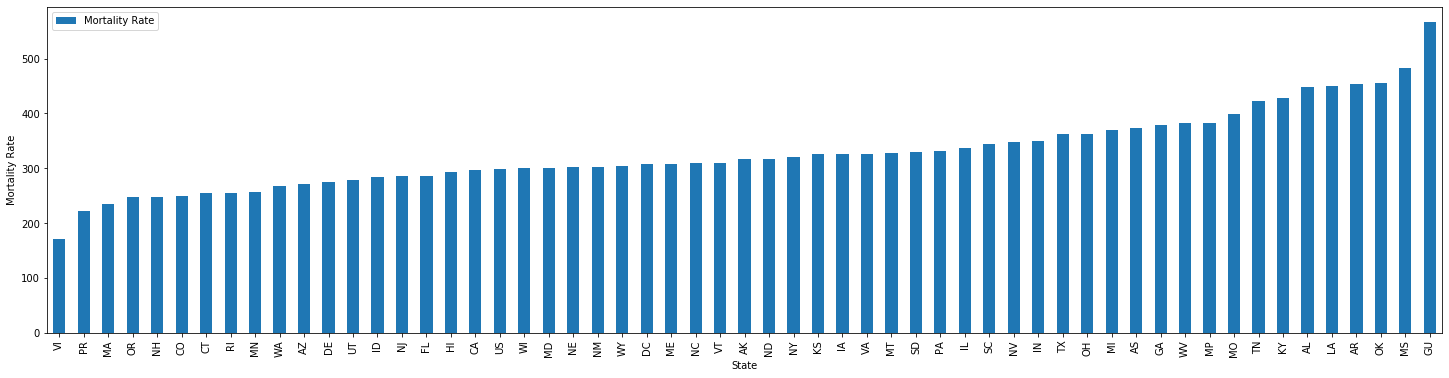

In [22]:
state.groupby(['LocationAbbr']).mean().sort_values(by='Mortality Rate').plot(kind='bar', figsize=(25,6))
plt.xlabel('State')
plt.ylabel('Mortality Rate')
plt.show()

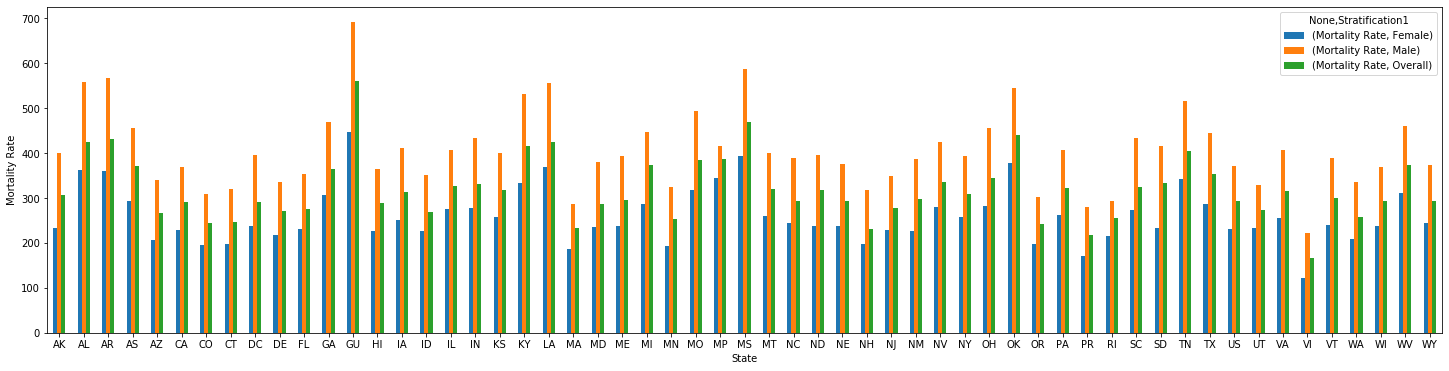

In [23]:
rcParams['figure.figsize']=25,6
grouped = state.dropna().groupby(['LocationAbbr','Stratification1']).mean()
grouped.unstack(level=[1]).plot.bar(stacked=False, legend=True, rot=0)
plt.xlabel('State')
plt.ylabel('Mortality Rate')
plt.show()

### Data Transformation and Feature Engineering  

The Location1 column is type string. To extract more meaninful data from this column it is converted to coordinates into two seperate columns which are then converted to type float to be used as a continous variable. Data_Value refers to the measurement of heart mortality and is a continous variable. Therefore, it is converted to type float as well.

- Split Location1 column into two separate columns Longitue and Latitue
- Convert the newly created Longitude and Latitude columns to type float
- Convert column Data_Value to type float


In [24]:
df['Mortality Rate'] = df['Mortality Rate'].astype('float')
df['Latitude'] = df['Location 1'].str.split(',').str[0].str[1:6].astype('float')
df['Longitude'] = df['Location 1'].str.split(',').str[1].str[:7].astype('float')

- State abbreviations, location description, data value type, gender, ethnicity, abd location ID are all converted to categorical variables

In [25]:
df['LocationAbbr'] = df['LocationAbbr'].astype('category') 
df['LocationDesc'] = df['LocationDesc'].astype('category') 
df['GeographicLevel'] = df['GeographicLevel'].astype('category') 
df['Data_Value_Type'] = df['Data_Value_Type'].astype('category') 
df['Stratification1'] = df['Stratification1'].astype('category') 
df['Stratification2'] = df['Stratification2'].astype('category') 
df['LocationID'] = df['LocationID'].astype('category')

In [26]:
df2 = df[['Year','Mortality Rate', 'Latitude', 'Longitude', 'LocationAbbr', 'LocationDesc', 'GeographicLevel', 'Data_Value_Type', 'Stratification2', 'LocationID', 'Stratification1']]

In [27]:
df2.head()

,Year,Mortality Rate,Latitude,Longitude,LocationAbbr,LocationDesc,GeographicLevel,Data_Value_Type,Stratification2,LocationID,Stratification1
0,2015,136.6,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,5,Overall
1,2015,138.3,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,5,Male
2,2015,130.4,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,5,Female
3,2015,456.2,-14.20,-170.30,AS,American Samoa,State,"Age-adjusted, 3-year Average Rate",Overall,60,Male
4,2015,294.1,-14.20,-170.30,AS,American Samoa,State,"Age-adjusted, 3-year Average Rate",Overall,60,Female


- Check for missing values

In [28]:
#Check for missing values
print('Missing Values: ')
print(df2.isna().sum())

Missing Values: 
Year                   0
Mortality Rate     27177
Latitude              18
Longitude             18
LocationAbbr           0
LocationDesc           0
GeographicLevel        0
Data_Value_Type        0
Stratification2        0
LocationID             0
Stratification1        0
dtype: int64


In [29]:
states = df2['LocationAbbr'].unique()
ethnicities = df2['Stratification2'].unique()

In [30]:
idx = pd.IndexSlice

- To make use of the categorical variables they are encoded as dummy variables using the pandas get dummies method.

In [31]:
df2['State-Strat2'] = df2['LocationAbbr'].astype('str')+df2['Stratification2'].astype('str')

In [32]:
df2.head()

,Year,Mortality Rate,Latitude,Longitude,LocationAbbr,LocationDesc,GeographicLevel,Data_Value_Type,Stratification2,LocationID,Stratification1,State-Strat2
0,2015,136.6,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,5,Overall,ARHispanic
1,2015,138.3,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,5,Male,ARHispanic
2,2015,130.4,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,5,Female,ARHispanic
3,2015,456.2,-14.20,-170.30,AS,American Samoa,State,"Age-adjusted, 3-year Average Rate",Overall,60,Male,ASOverall
4,2015,294.1,-14.20,-170.30,AS,American Samoa,State,"Age-adjusted, 3-year Average Rate",Overall,60,Female,ASOverall


In [33]:
grouped_data_value = df2[['Mortality Rate', 'State-Strat2']].groupby(['State-Strat2']).median().dropna()

- Impute median grouped by location and stratification2 for missing values.

In [34]:
for i in grouped_data_value.index:
            if ((df2['LocationAbbr']==i[:2]) & (df2['Stratification2']==i[2:])).any():
                df2['Mortality Rate'].fillna(grouped_data_value.loc[idx[i],:].values[0], inplace=True) #.values passes in an array. To get the median slice the array at o index.
            else:
                df2['Mortality Rate'].fillna(df2['Mortality Rate'].median(), inplace=True)

In [35]:
df2.dropna(inplace=True) ##drop entries with missing latitude and longitude

In [36]:
df2.isna().sum()

Year               0
Mortality Rate     0
Latitude           0
Longitude          0
LocationAbbr       0
LocationDesc       0
GeographicLevel    0
Data_Value_Type    0
Stratification2    0
LocationID         0
Stratification1    0
State-Strat2       0
dtype: int64

In [37]:
df2 = df2[['Mortality Rate', 'Latitude', 'Longitude', 'LocationAbbr', 'LocationDesc', 'GeographicLevel', 'Data_Value_Type', 'Stratification2', 'Stratification1']]
df2.head()

,Mortality Rate,Latitude,Longitude,LocationAbbr,LocationDesc,GeographicLevel,Data_Value_Type,Stratification2,Stratification1
0,136.6,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,Overall
1,138.3,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,Male
2,130.4,34.89,-92.43,AR,Arkansas,State,"Age-adjusted, 3-year Average Rate",Hispanic,Female
3,456.2,-14.20,-170.30,AS,American Samoa,State,"Age-adjusted, 3-year Average Rate",Overall,Male
4,294.1,-14.20,-170.30,AS,American Samoa,State,"Age-adjusted, 3-year Average Rate",Overall,Female


- Create dummy variables for all categorical columns except for Startification1

In [38]:
def get_dummies(dataframe, *columns):
    
    encoded_dataframe = pd.DataFrame(index=dataframe.index)
    for i in columns:
        encoded_dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[i], prefix=i)], axis=1)
    
    return encoded_dataframe

In [39]:
model_data = get_dummies(df2, [ 'LocationAbbr', 'LocationDesc', 'GeographicLevel', 'Data_Value_Type', 'Stratification2'])

In [40]:
cols = ['LocationAbbr', 'LocationDesc', 'GeographicLevel', 'Data_Value_Type', 'Stratification2']

In [41]:
model_data = model_data[[i for i in model_data.columns if i not in cols]]

- Select observations with mortality rate greater than 0.

In [42]:
model_data = model_data[model_data['Mortality Rate']>0]
pd.concat([model_data['Mortality Rate'].describe(), np.log(model_data['Mortality Rate']).describe()], 
          axis=1, 
          keys=['Normal', 'Log Transformed'])

,Normal,Log Transformed
count,59056.000000,59056.000000
mean,392.537403,5.916614
std,116.112222,0.367561
min,4.000000,1.386294
25%,324.000000,5.780744
50%,446.750000,6.101999
75%,446.750000,6.101999
max,5161.700000,8.549021


- Mortality rate with and without log normal transformation

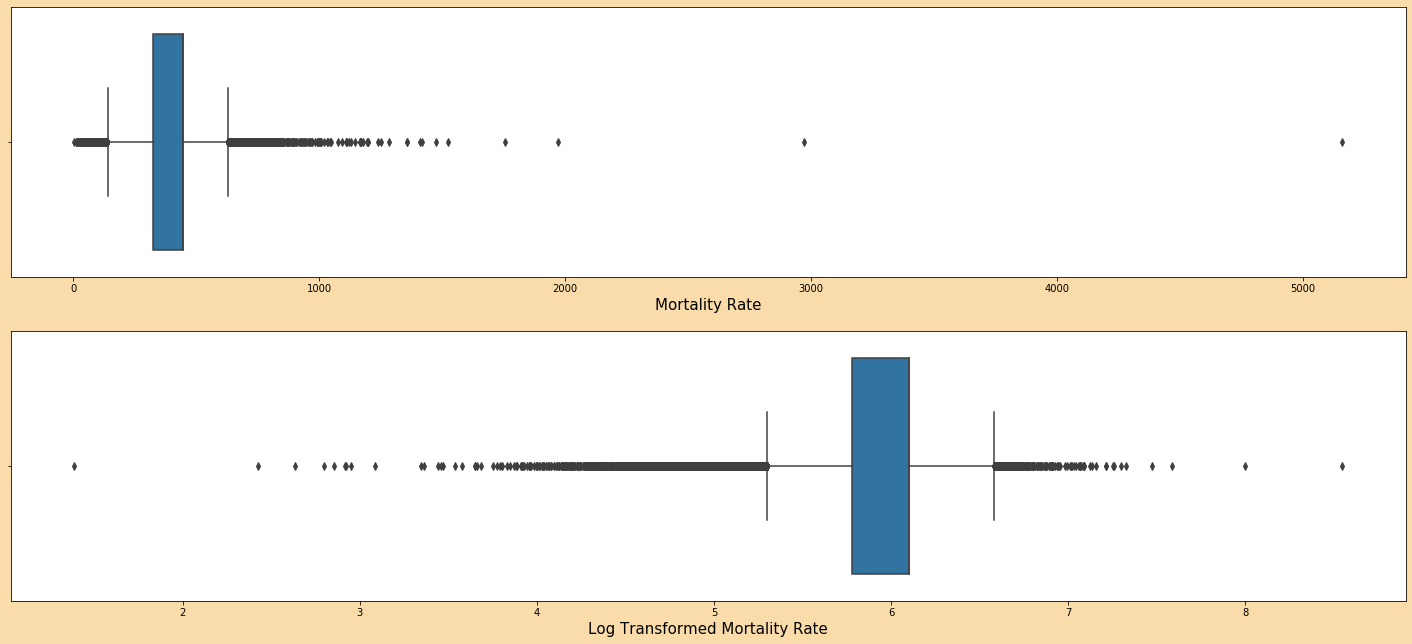

In [43]:
fig, ax = plt.subplots(2,1)
ax1 = sns.boxplot(x=model_data['Mortality Rate'], ax=ax[0])
ax1.set_xlabel('Mortality Rate', fontsize=15)
ax2 = sns.boxplot(x=np.log(model_data['Mortality Rate']), ax=ax[1])
ax2.set_xlabel('Log Transformed Mortality Rate', fontsize=15)
fig.set_facecolor('#fadcaa')
plt.subplots_adjust(top=1.5)
plt.show()

In [44]:
model_data['Mortality Rate'] = np.log(model_data['Mortality Rate'])

# Declare independent and dependent variables

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# dependent vs. independent variables
x = model_data[[i for i in model_data.columns if i!='Stratification1']]
y = model_data['Stratification1']

- Feature Selection

In [47]:
from sklearn.feature_selection import GenericUnivariateSelect, f_classif

In [48]:
x.shape

(59056, 2086)

In [49]:
#in the case below we use 20% of the original feature set
#f_classif gives ANOVA F_values to rank the features based on importance
feature_selector = GenericUnivariateSelect(f_classif, mode='percentile', param=5) #params defines the number of features to select if k-best or percentage of features if percentile
x_select = feature_selector.fit_transform(x, y)

In [50]:
x_select = x.iloc[:,feature_selector.get_support(indices=True)] #get support gives an array of indices of the retained columns

In [51]:
x_select.tail()

,Mortality Rate,Latitude,Longitude,LocationAbbr_AK,LocationAbbr_AL,LocationAbbr_AR,LocationAbbr_AZ,LocationAbbr_CA,LocationAbbr_CO,LocationAbbr_CT,...,GeographicLevel_County,GeographicLevel_State,"Data_Value_Type_Age-adjusted, 3-year Average Rate","Data_Value_Type_Age-adjusted, Spatially Smoothed, 3-year Average Rate",Stratification2_American Indian and Alaskan Native,Stratification2_Asian and Pacific Islander,Stratification2_Black,Stratification2_Hispanic,Stratification2_Overall,Stratification2_White
59071,5.818895,42.76,-109.90,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
59072,5.136386,43.92,-110.50,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
59073,5.751302,41.65,-108.80,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
59074,6.101999,39.27,-80.71,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
59075,6.101999,38.71,-81.35,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


# Train-Test Split

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_select, y, test_size=0.20, random_state=123)

### Models:
1. Logistic Regression
2. Gaussian Naive Bayes
3. Decision Tress
4. Random Forest
5. Supoort Vector Machine

- Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

In [55]:
logit_model = LogisticRegression(multi_class='ovr', solver='liblinear')
logit_fit = logit_model.fit(x_train, y_train)

In [56]:
logit_predict = logit_model.predict(x_test)
logit_predict_prob = logit_model.predict_proba(x_test)

In [57]:
labelencoder = LabelEncoder()
y_test_encoded = labelencoder.fit_transform(y_test)
logit_predict_encoded = labelencoder.fit_transform(logit_predict)

In [58]:
print('ROC Accuracy of a Logistic Regression Model: ', round(roc_auc_score(y_test, logit_predict_prob, multi_class='ovr'),3)*100, '%')

ROC Accuracy of a Logistic Regression Model:  61.4 %


In [59]:
logit_confusion_matrix = pd.crosstab(y_test.values,
                                     logit_predict,
                                     rownames=['Actual'],
                                     colnames=['Predicted'],
                                     margins=False)
logit_confusion_matrix

Predicted,Female,Male,Overall
Actual,,,
Female,1929,1586,381
Male,819,2833,375
Overall,1557,1962,370


- Naive Bayes

In [60]:
from sklearn.naive_bayes import GaussianNB

In [61]:
nb_model = GaussianNB()
nb_fit = nb_model.fit(x_train, y_train)

In [62]:
nb_predict = nb_fit.predict(x_test)
nb_predict_proba = nb_fit.predict_proba(x_test)

In [63]:
nb_predict_encoded = labelencoder.fit_transform(nb_predict)

In [64]:
pd.crosstab(y_test.values,
            nb_predict,
            rownames=['Actual'],
            colnames=['Predicted'],
            margins=False)

Predicted,Female,Male,Overall
Actual,,,
Female,1827,1270,799
Male,1599,1613,815
Overall,1924,1373,592


In [65]:
print('ROC Accuracy of a Naive Bayes Model: ', round(roc_auc_score(y_test, nb_predict_proba, multi_class='ovr'),3)*100, '%')

ROC Accuracy of a Naive Bayes Model:  49.6 %


- Decision Trees

In [67]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
decision_tree_accuracy = {}
for depth in range(1,25):
    dt_model = DecisionTreeClassifier(random_state=123, max_depth=depth)
    dt_fit = dt_model.fit(x_train, y_train)
    dt_predict = dt_fit.predict(x_test)
    dt_predict_proba = dt_fit.predict_proba(x_test)
    dt_auc_accuracy = roc_auc_score(y_test_encoded, dt_predict_proba, multi_class='ovr')
    decision_tree_accuracy[depth] = dt_auc_accuracy

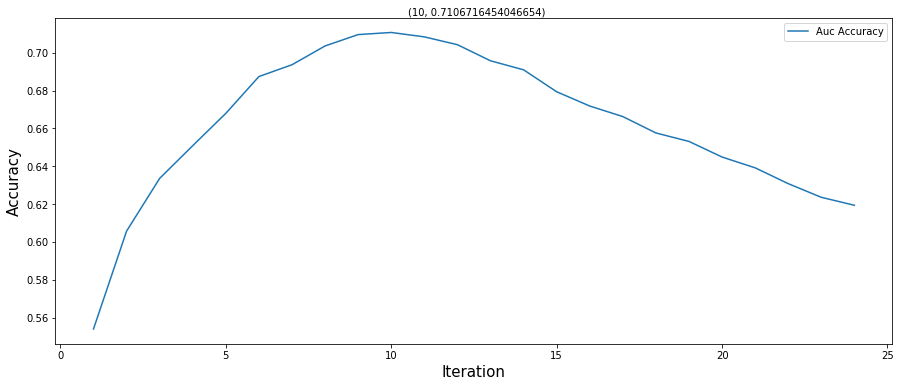

In [70]:
dt_accuracy_df = pd.DataFrame.from_dict(decision_tree_accuracy, orient='index', columns=['Auc Accuracy'])
fig = dt_accuracy_df.plot(figsize=(15,6))
fig.annotate((dt_accuracy_df['Auc Accuracy'].idxmax(), max(dt_accuracy_df['Auc Accuracy'])),
            xy=(dt_accuracy_df.idxmax(), max(dt_accuracy_df['Auc Accuracy'])),
            xytext=(10.5, 0.72))
# plt.legend('Auc', fontsize=10, loc=2, prop={'size':10})
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.style.use('ggplot')
plt.show()

Using an iterative approach to select tree depth the max accuracy achieved is when the tree depth is 10. Using this as the tree depth the final model is built which will be used to make preidictions

In [73]:
dt_model = DecisionTreeClassifier(random_state=123, max_depth=10)
dt_fit = dt_model.fit(x_train, y_train)
dt_predict = dt_fit.predict(x_test)
dt_predict_proba = dt_fit.predict_proba(x_test)
print('ROC Accuracy of the Decision Tree Model: ', round(roc_auc_score(y_test_encoded, dt_predict_proba, multi_class='ovr'),3)*100, '%')

ROC Accuracy of the Decision Tree Model:  71.1 %


In [74]:
pd.crosstab(y_test.values,
           dt_predict,
           rownames=['Actuals'],
           colnames=['Predictions'],
           margins=False)

Predictions,Female,Male,Overall
Actuals,,,
Female,3165,166,565
Male,1918,1523,586
Overall,2084,503,1302


- Random Forest 

In [75]:
from sklearn.ensemble import RandomForestClassifier 

In [76]:
rf_accuracy = {}
for depth in range(1,51):
    rf_model = RandomForestClassifier(max_depth=depth, random_state=123, max_samples=3120) #using the number of columns * 30 as a statistical method for bootstratpping (law of large numbers)
    rf_fit = rf_model.fit(x_train, y_train)
    rf_predict_proba = rf_fit.predict_proba(x_test)
    rf_roc_accuracy = roc_auc_score(y_test, rf_predict_proba, multi_class='ovr')
    rf_accuracy[depth] = rf_roc_accuracy

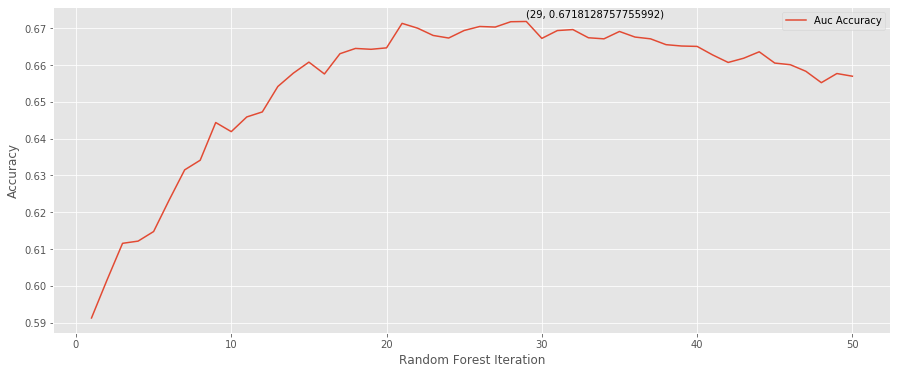

In [77]:
rf_accuracy_df = pd.DataFrame.from_dict(rf_accuracy, orient='index', columns=['Auc Accuracy'])
fig = rf_accuracy_df.plot(figsize=(15,6))
fig.annotate(((rf_accuracy_df['Auc Accuracy'].idxmax(),max(rf_accuracy_df['Auc Accuracy']))),
            xy=((rf_accuracy_df['Auc Accuracy'].idxmax(),max(rf_accuracy_df['Auc Accuracy']))),
            xytext=(29,0.673))
plt.ylabel('Accuracy')
plt.xlabel('Random Forest Iteration')
plt.show()

The graph above shows that max ROC accuracy is achieved at iteration 29. Using max tree depth of 29 a random forest model is built again below to make prediction.

In [78]:
rf_model = RandomForestClassifier(max_depth=29, random_state=123, max_samples=3120)
rf_fit = rf_model.fit(x_train, y_train)
rf_predict = rf_fit.predict(x_test)
rf_predict_proba = rf_fit.predict_proba(x_test)
pd.crosstab(y_test,
           rf_predict,
           rownames=['Actuals'],
           colnames=['Predictions'],
           margins=False)

Predictions,Female,Male,Overall
Actuals,,,
Female,1971,961,964
Male,1084,1954,989
Overall,1291,1177,1421


In [79]:
print('ROC Accuracy of the Random Forest Model: ', round(roc_auc_score(y_test, rf_predict_proba, multi_class='ovr'),3)*100, "%")

ROC Accuracy of the Random Forest Model:  67.2 %


- Support Vector Machines

In [80]:
from sklearn.svm import LinearSVC

In [81]:
svm_y_train = labelencoder.fit_transform(y_train)

In [82]:
svm_model = LinearSVC()
svm_fit = svm_model.fit(x_train , svm_y_train)
svm_predict = svm_fit.predict(x_test)
svm_predict_encoded = labelencoder.fit_transform(svm_predict)
# svm_predict_proba = svm_fit.predict_proba(x_test)

In [83]:
from sklearn.preprocessing import OneHotEncoder

In [84]:
one_hot_encoder = OneHotEncoder()
one_hot_svm_predicted = one_hot_encoder.fit_transform(svm_predict_encoded.reshape(-1,1)).toarray()
one_hot_y_test = one_hot_encoder.fit_transform(y_test_encoded.reshape(-1,1)).toarray()

In [85]:
#for binary predicted values with multiple classes the roc_auc_score requires encoding the feature first
#encoding is only required for the predicted values
print('AUC Accuracy of a SVM Linear Model: ', round(roc_auc_score(one_hot_y_test, one_hot_svm_predicted, multi_class='ovr')*100,2), '%') 

AUC Accuracy of a SVM Linear Model:  56.94 %
